In [1]:
!pip install efficientnet

import cv2
import os
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from efficientnet.keras import EfficientNetB3



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.4 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Define your custom callback
class MyCallback(Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.batches == 0 and epoch > 0:
            tr_acc = logs.get('accuracy')
            v_loss = logs.get('val_loss')

            if tr_acc > self.highest_tracc:
                self.highest_tracc = tr_acc

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
                self.best_weights = self.model.get_weights()
                self.count = 0
            else:
                self.count += 1

            if tr_acc >= self.threshold:
                self.ask_epoch -= 1

            if self.count == self.patience and self.ask_epoch > 0:
                print("\nEpoch %d: Accuracy threshold reached. Decreasing learning rate." % (epoch + 1))
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                new_lr = old_lr * self.factor
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                print("Learning rate decreased from %f to %f" % (old_lr, new_lr))
                self.count = 0

            if self.count == self.patience and self.ask_epoch == 0:
                self.stop_count += 1
                if self.stop_count == self.stop_patience:
                    print("\nTraining stopped at epoch %d" % (epoch + 1))
                    self.model.stop_training = True
                else:
                    print("\nEpoch %d: Learning rate adjustment limit reached. Restoring best weights." % (epoch + 1))
                    self.model.set_weights(self.best_weights)
                    self.count = 0

In [3]:
# Set the data path and categories
data_path = '/kaggle/input/kao-1500/MedicalExpert-I'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 256
data = []
label = []

# Load the images and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            data.append(resized)
            label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

data = np.array(data) / 255.0
data_rgb = np.repeat(data[..., np.newaxis], 3, -1)
label = np.array(label)
new_label = np_utils.to_categorical(label)

# Split the data into train, test, and validation sets
x_train, x_test, y_train, y_test = train_test_split(data_rgb, new_label, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

# Define the data generators
datagen_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen_val = ImageDataGenerator()

train_generator = datagen_train.flow(x_train, y_train, batch_size=32)
val_generator = datagen_val.flow(x_val, y_val, batch_size=32)

In [8]:
import cv2
import os
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from efficientnet.keras import EfficientNetB3
# Construct the EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3), pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(len(categories), activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 1536)             10783528  
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 11,184,429
Trainable params: 11,094,061


In [9]:
# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Set up your custom callback
my_callback = MyCallback(model=model, patience=10, stop_patience=5, threshold=0.9, factor=0.1, batches=10, epochs=100, ask_epoch=10)

# Train the model
history = model.fit(train_generator,
                    epochs=90,
                    validation_data=val_generator,
                    callbacks=[checkpoint, my_callback])

Epoch 1/90


2023-06-26 15:33:56.352739: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnet-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - ETA: 0s - loss: 9.4839 - accuracy: 0.3671
Epoch 1: val_accuracy improved from -inf to 0.27273, saving model to /kaggle/working/model2.h5
37/37 [==============================] - 102s 894ms/step - loss: 9.4839 - accuracy: 0.3671 - val_loss: 11.9677 - val_accuracy: 0.2727
Epoch 2/90
37/37 [==============================] - ETA: 0s - loss: 8.4563 - accuracy: 0.4684
Epoch 2: val_accuracy did not improve from 0.27273
37/37 [==============================] - 31s 820ms/step - loss: 8.4563 - accuracy: 0.4684 - val_loss: 9.6590 - val_accuracy: 0.2727
Epoch 3/90
37/37 [==============================] - ETA: 0s - loss: 7.7947 - accuracy: 0.5437
Epoch 3: val_accuracy did not improve from 0.27273
37/37 [==============================] - 30s 802ms/step - loss: 7.7947 - accuracy: 0.5437 - val_loss: 9.0388 - val_accuracy: 0.2727
Epoch 4/90
37/37 [==============================] - ETA: 0s - loss: 7.3056 - accuracy: 0.5844
Epoch 4: val_accuracy improved from 0.27

In [10]:
# Load the best weights
model.load_weights('/kaggle/working/model2.h5')


Test loss: 0.9638700485229492
Test accuracy: 0.8515151739120483


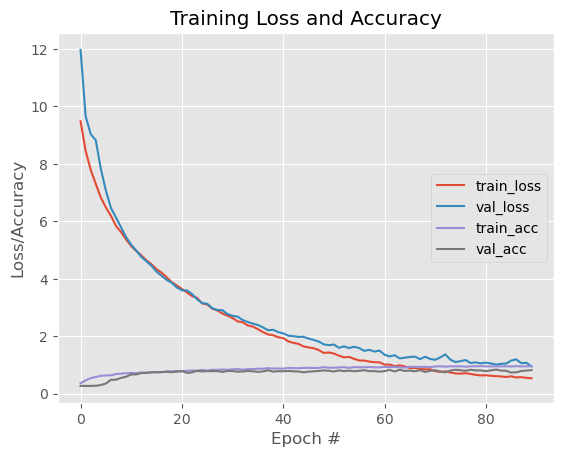

In [11]:
# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("EfficientNet_Model")

# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)